In [1]:
#!/usr/bin/env python

# Plot_MCS-tracking-examples.ipynb

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


###  USER INPUT SECTION

In [3]:
trackers = ['Andreas', 'Julia','Amanda', 'Kelly-Zach', 'Zhe','TOOCAN']
track_name = ['prein', 'kukulies','Rehbein', 'TAMS', 'feng','TOOCAN']
tracker_names = ['MOAAP', 'tobac','ForTraCC', 'TAMS', 'PyFLEXTRKR','TOOCAN']
tr_colors = ['#1f78b4','#33a02c','#e31a1c','#ff7f00','#a6cee3','#cab2d6']

case = 'Arg_20181208'

### Read the precipitation and Tb data

In [4]:
if case == 'Arg_20181208':
    ncid = Dataset('/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/2018/merg_2018120900_4km-pixel.nc', mode='r')
    Lat = np.squeeze(ncid.variables['lat'][:])
    Lon = np.squeeze(ncid.variables['lon'][:])
    tb = np.squeeze(ncid.variables['Tb'][:])
    pr = np.squeeze(ncid.variables['precipitationCal'][:])
    ncid.close()
    
    time = pd.date_range(datetime.datetime(2018, 6, 1,0), end=datetime.datetime(2019, 5, 31,23), freq='h')
    foc_time = pd.date_range(datetime.datetime(2018, 12, 8, 17), end=datetime.datetime(2018, 12, 10,17), freq='h')
    tar_time = datetime.datetime(2018, 12, 9, 1)
    
    mcs_index_andreas = 1722
    
#     time_steps_y = [[4577,4625],
#                    [185,233],
#                    [4577,4625],
#                    [4577,4625],
#                    [4577,4625]]
#     tar_time = [4585,
#                193,
#                4585,
#                4585,
#                4585]
#     mcs_index = [[1722],
#                  [702], # add month plus four zeros
#                  [1968],
#                  [21971],
#                  [2494]] 
    
    file_name = ['prein_WY2019_OBS_SAAG-MCS-mask-file.nc',
                 'kukulies_WY2019-12_OBS_SAAG-MCS-mask-file.nc',
                 'Rehbein_WY2019_OBS_SAAG-MCS-mask-file.nc',
                 'TAMS_WY2019_OBS_SAAG-MCS-mask-file.nc',
                 'feng_WY2019_OBS_SAAG-MCS-mask-file.nc',
                 'TOOCAN_WY2019_OBS_SAAG-MCS-mask-file.nc']
    track_file = '_OBS_MCS_WY2019.pkl'

Lon,Lat = np.meshgrid(Lon,Lat)
month = foc_time[0].month
time_cut_yy = np.isin(time, foc_time)
time_cut_mm = np.isin(time[time.month == month], foc_time)
foc_time_ind = (foc_time.day == tar_time.day) & (foc_time.hour == tar_time.hour)

### Read masks from tracker

In [5]:
mcs_mask = np.zeros((len(foc_time),Lat.shape[0], Lat.shape[1], len(trackers)))
for tr in range(len(trackers)):
    if trackers[tr] != 'Julia':
        time_sel = time_cut_yy
    else:
        time_sel = time_cut_mm
        
    ncid = Dataset('/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/'+trackers[tr]+'/'+file_name[tr], mode='r')
    mcs_mask[:,:,:,tr] = np.squeeze(ncid.variables['mcs_mask'][np.where(time_sel == 1)[0][0] : np.where(time_sel == 1)[0][-1]+1, :])
    ncid.close()
    

In [6]:
# get the mcs index for all trackers
mask_andreas = mcs_mask[:,:,:,trackers.index('Andreas')] == mcs_index_andreas
mcs_indices = {}
for tr in range(len(trackers)):
    ind_tmp = np.delete(np.unique(mcs_mask[:,:,:,tr] * mask_andreas).astype(int), 0)
    ind_tmp = ind_tmp[ind_tmp > 0]
    mcs_indices[trackers[tr]] = ind_tmp

### Read MCS tracks

In [7]:
mcs_analysis = {}
track_folder = '/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/MCS_characteristics/'
for tr in range(len(trackers)):
    file = open(track_folder + trackers[tr] + track_file, 'rb')
    mcs_analysis[trackers[tr]] = pickle.load(file, encoding='latin1')

### Plot the data on a map

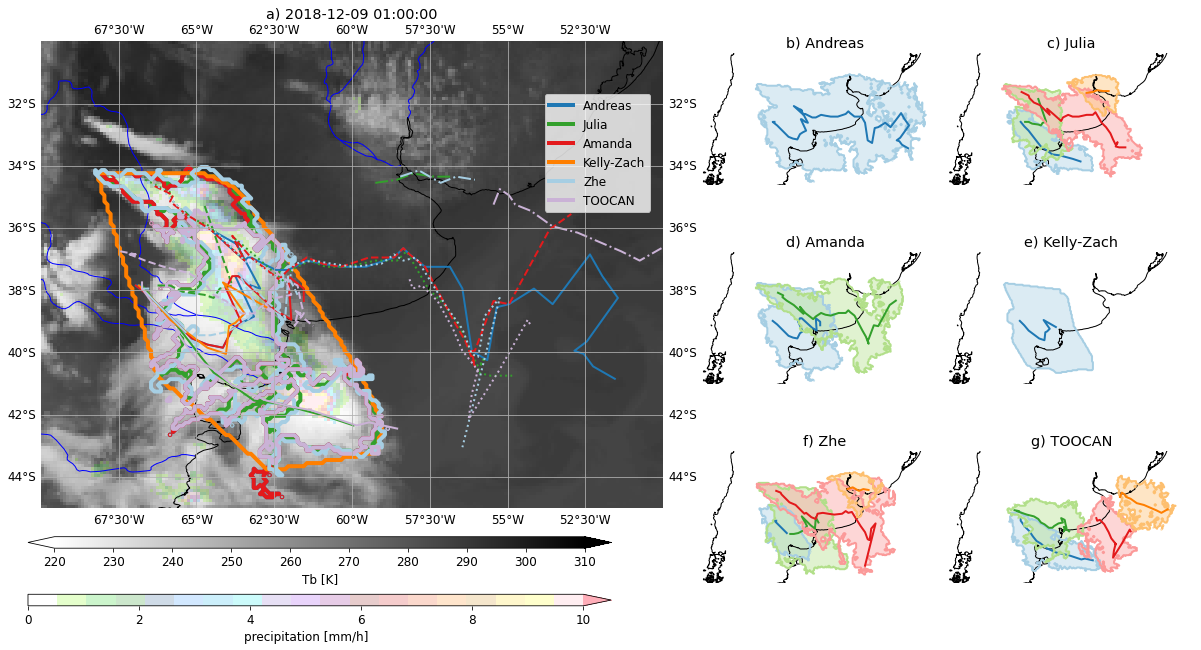

In [8]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

import seaborn as sns
from scipy.stats import kde
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

fig = plt.figure(figsize=(18,8))
import seaborn as sns
plt.rcParams.update({'font.size': 12})
# Histogram plots
gs1 = gridspec.GridSpec(1,1) #rgiSize[2])
gs1.update(left=0.06, right=0.54,
           bottom=0.1, top=0.97,
           wspace=0.0, hspace=0.05)

# Plot the MCS Origin in Stage IV and CONUS404
proj = ccrs.PlateCarree() #ccrs.Robinson() 

# --------------------------------
# Plot precipitation from IMERG and WRF
COLORS = ["#ffffff", "#7fff00", "#00cd00", "#008b00", "#104e8b",
   "#1e90ff", "#00b2ee", "#00eeee", "#8968cd", "#912cee",
   "#8b008b", "#8b0000", "#cd0000", "#ee4000", "#ff7f00",
   "#cd8500", "#ffd700", "#ffff00", "#ffaeb9"]
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
cmap = matplotlib.colors.ListedColormap(COLORS)

ax = plt.subplot(gs1[0,0], projection=proj)
plt.axis('off')
ax.set_extent((-70, -50, -45, -30), ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')

# PLOT TB
cs = ax.pcolormesh(Lon, Lat, np.nanmean(tb, axis=0), transform=ccrs.PlateCarree(), cmap='gray_r', vmin=220, vmax=310, alpha=1)
# create legend
for tr in range(len(trackers)):
    ax.plot([],[],color = tr_colors[tr], lw=4, label = trackers[tr])
plt.legend(bbox_to_anchor=(0.8,0.9))
plt.title(rgsLableABC[0]+') '+str(tar_time))
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

CbarAx = axes([0.05, 0.06, 0.45, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=LEVS)
cb.set_label('Tb [K]') #, fontsize=12)

# PLOT PRECIPITATION
pr_nan = np.nanmean(pr, axis=0)
pr_nan[pr_nan < 0.5] = np.nan
cs = ax.pcolormesh(Lon, Lat, pr_nan, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=10, alpha=0.2)

CbarAx = axes([0.05, -0.04, 0.45, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max') #, ticks=LEVS)
cb.set_label('precipitation [mm/h]') #, fontsize=12)

# PLOT OUTLINE OF MASK FOR THIS TIME STEP
for tr in range(len(trackers)):
    ax.contour(Lon, Lat, np.isin(np.squeeze(mcs_mask[foc_time_ind,:,:,tr]), mcs_indices[trackers[tr]]) , 
                transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = tr_colors[tr], linewidths=4)
#     ax.plot([],[],color = tr_colors[tr], lw=4, label = trackers[tr])
# plt.legend() #(bbox_to_anchor=(0.9,40))


# PLOT MCS TRACKS
line_styles = ['-','--',':','-.']
for tr in range(len(trackers)):
    ind_tmp = mcs_indices[trackers[tr]]
    for ii in range(len(ind_tmp)):
        ind_act = ind_tmp[ii]
        if trackers[tr] == 'Julia':
            ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], 
                    mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
                     transform=ccrs.PlateCarree(), c = tr_colors[tr], lw=2, ls = line_styles[ii])
#             ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], +
#                     mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
#                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
        else:
            ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
                     transform=ccrs.PlateCarree(), c = tr_colors[tr], lw=2, ls = line_styles[ii])
#             ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
#                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)

    

# PLOT TRACKS SEPERATELY
gs1 = gridspec.GridSpec(3,2) #rgiSize[2])
gs1.update(left=0.57, right=0.95,
           bottom=-0.05, top=0.97,
           wspace=0.0, hspace=0.05)

# PLOT MCS TRACKS
line_styles = ['-','--',':','-.']
XX = [0,1,0,1,0,1]
YY = [0,0,1,1,2,2]
mcs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
for tr in range(len(trackers)):
    ax = plt.subplot(gs1[YY[tr], XX[tr]], projection=proj)
    plt.axis('off')
    ax.set_extent((-75, -47, -45, -30), ccrs.PlateCarree())
    ax.coastlines()
    
    ind_tmp = mcs_indices[trackers[tr]]
    for ii in range(len(ind_tmp)):
        # plot outline of each MCS
#         for tt in range(mcs_mask.shape[0])[::2]:
        mcs_footprint = np.sum(mcs_mask[:,:,:,tr] == ind_tmp[ii], axis=0) > 0
        mcs_footprint[mcs_footprint == 0] == np.nan
        ax.contourf(Lon, Lat, mcs_footprint, 
                transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = mcs_colors[ii*2], alpha=0.4)
        ax.contour(Lon, Lat, mcs_footprint, 
                transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = mcs_colors[ii*2], linewidths=2, zlevel = 10)
    
        # plot track
        ind_act = ind_tmp[ii]
        if trackers[tr] == 'Julia':
            ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], 
                    mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
                     transform=ccrs.PlateCarree(), c = mcs_colors[ii*2+1], lw=2, ls = '-')
#             ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], +
#                     mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
#                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
        else:
            ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
                     transform=ccrs.PlateCarree(), c = mcs_colors[ii*2+1], lw=2, ls = '-')
#             ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
#                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
    plt.title(rgsLableABC[tr+1]+') '+trackers[tr])
        
        
# # sPlotFile=sPlotDir
# # sPlotName= str(TimeMM.year[0])+'-'+str(TimeMM.year[-1])+'_MCS-precipitation-ratio.pdf'
# # if os.path.isdir(sPlotFile) != 1:
# #     subprocess.call(["mkdir","-p",sPlotFile])
# # fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
# # print( '        Plot map to: '+sPlotFile+sPlotName)

In [9]:
mcs_indices

{'Andreas': array([1722]),
 'Julia': array([680, 702, 721, 764]),
 'Amanda': array([1968, 1977]),
 'Kelly-Zach': array([1995]),
 'Zhe': array([2490, 2494, 2499, 2510]),
 'TOOCAN': array([ 92542,  92554, 105173, 131631])}

### Alternative plot

In [10]:
# get Tb and PR data for the entire case

time_case = pd.date_range(datetime.datetime(2018, 12, 8,0), end=datetime.datetime(2018, 12, 9,23), freq='h')

tb_case = np.zeros((len(time_case), tb.shape[1], tb.shape[2])); tb_case[:] = np.nan
pr_case = np.copy(tb_case)

for hh in tqdm(range(len(time_case))):
    YYYY = str(time_case[hh].year)
    MM = str(time_case[hh].month).zfill(2)
    DD = str(time_case[hh].day).zfill(2)
    HH = str(time_case[hh].hour).zfill(2)
    ncid = Dataset('/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/2018/merg_'+YYYY+MM+DD+HH+'_4km-pixel.nc', mode='r')
    tb_case[hh,:,:] = np.squeeze(ncid.variables['Tb'][:])[0,:]
    pr_case[hh,:,:] = np.squeeze(ncid.variables['precipitationCal'][0,:])
    ncid.close()

100%|██████████| 48/48 [00:06<00:00,  7.44it/s]


(-45.0, -30.0)

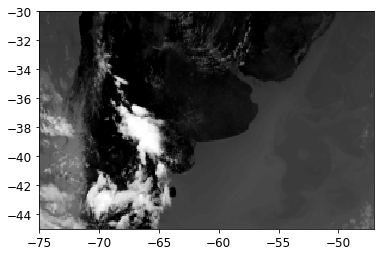

In [11]:
hh = 18
plt.pcolormesh(Lon, Lat, tb_case[hh], cmap='gray_r', vmin=220, vmax=310, alpha=1)
plt.xlim((-75, -47))
plt.ylim((-45, -30))


In [12]:
hh_sel = [18,20,22,24,26,28]

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Fig_03_2018-12_MCS-case.jpg


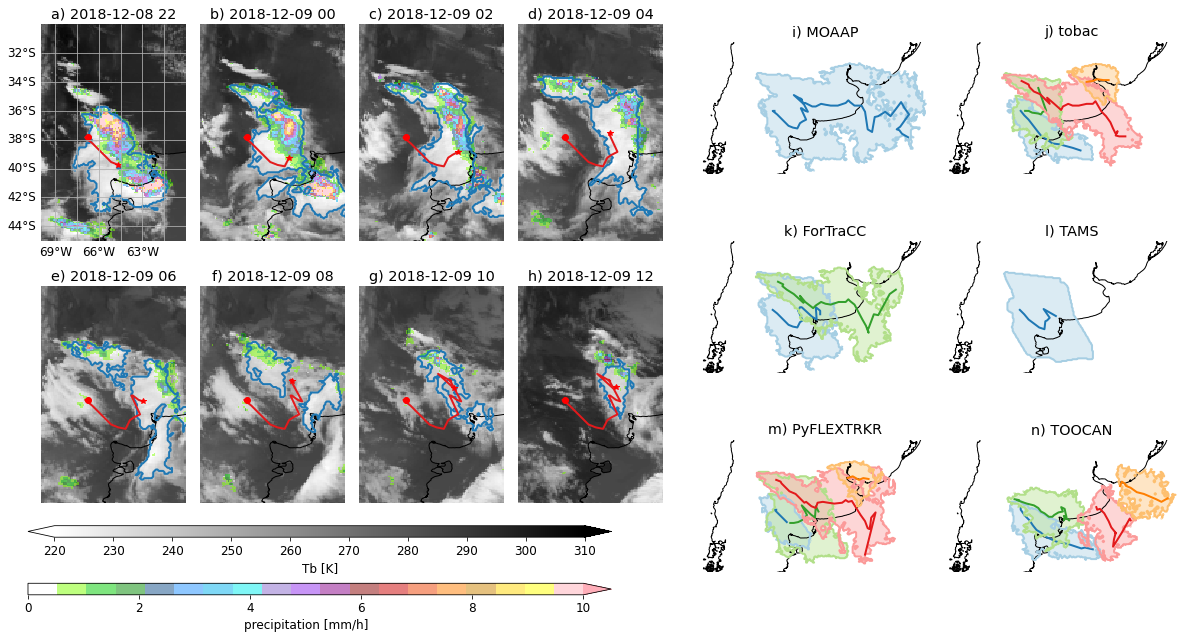

In [13]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

import seaborn as sns
from scipy.stats import kde
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

fig = plt.figure(figsize=(18,8))
import seaborn as sns
plt.rcParams.update({'font.size': 12})
# Histogram plots
gs1 = gridspec.GridSpec(2,4) #rgiSize[2])
gs1.update(left=0.06, right=0.54,
           bottom=0.1, top=0.97,
           wspace=0.1, hspace=0.1)

# Plot the MCS Origin in Stage IV and CONUS404
proj = ccrs.PlateCarree() #ccrs.Robinson() 

# --------------------------------
# Plot precipitation from IMERG and WRF
COLORS = ["#ffffff", "#7fff00", "#00cd00", "#008b00", "#104e8b",
   "#1e90ff", "#00b2ee", "#00eeee", "#8968cd", "#912cee",
   "#8b008b", "#8b0000", "#cd0000", "#ee4000", "#ff7f00",
   "#cd8500", "#ffd700", "#ffff00", "#ffaeb9"]
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
cmap = matplotlib.colors.ListedColormap(COLORS)

XX = [0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1]
hh_sel = [22,24,26,28,30,32,34,36]
for hh in range(len(hh_sel)):
    ax = plt.subplot(gs1[YY[hh],XX[hh]], projection=proj)
    plt.axis('off')
    ax.set_extent((-70, -60, -45, -30), ccrs.PlateCarree())
    ax.coastlines()

    # PLOT TB
    cs = ax.pcolormesh(Lon, Lat, tb_case[hh_sel[hh]], transform=ccrs.PlateCarree(), cmap='gray_r', vmin=220, vmax=310, alpha=1)
    plt.title(rgsLableABC[hh]+') '+str(time_case[hh_sel[hh]])[:13])
    # ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    
    # PLOT PRECIPITATION
    pr_nan = pr_case[hh_sel[hh]]
    pr_nan[pr_nan < 0.5] = np.nan
    cs_pr = ax.pcolormesh(Lon, Lat, pr_nan, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=10, alpha=0.5)

    
    # PLOT OUTLINE OF MASK FOR THIS TIME STEP
    foc_time_ind = (foc_time.day == time_case[hh_sel[hh]].day) & \
                   (foc_time.hour == time_case[hh_sel[hh]].hour)
    foc_time_ii = where(foc_time_ind == True)[0][0]+2
    for tr in [0]: #range(len(trackers)):
        ax.contour(Lon, Lat, np.isin(np.squeeze(mcs_mask[foc_time_ind,:,:,tr]), mcs_indices[trackers[tr]]) , 
                    transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = tr_colors[tr], linewidths=2)
    
    if hh == 0:
        gf = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gf.right_labels = False
        gf.top_labels = False
    
    # PLOT MCS TRACKS
    line_styles = ['-','--',':','-.']
    for tr in [0]: #range(len(trackers)):
        ind_tmp = mcs_indices[trackers[tr]]
        for ii in range(len(ind_tmp)):
            ind_act = ind_tmp[ii]
            if trackers[tr] == 'Julia':
                ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], 
                        mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
                         transform=ccrs.PlateCarree(), c = tr_colors[tr], lw=2, ls = line_styles[ii])
    #             ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], +
    #                     mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
    #                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
            else:
                ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1][:foc_time_ii], 
                        mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0][:foc_time_ii],
                         transform=ccrs.PlateCarree(), c = '#e31a1c', lw=2, ls = line_styles[ii])
                # plot track start
                ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1][0], 
                        mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0][0],
                       'ro')
                # plot track end
                ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1][foc_time_ii-1], 
                        mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0][foc_time_ii-1],
                       'r*')
                
    #             ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
    #                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)

    
CbarAx = axes([0.05, 0.06, 0.45, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=LEVS)
cb.set_label('Tb [K]') #, fontsize=12)

CbarAx = axes([0.05, -0.04, 0.45, 0.02])
cb = colorbar(cs_pr, cax = CbarAx, orientation='horizontal', extend='max') #, ticks=LEVS)
cb.set_label('precipitation [mm/h]') #, fontsize=12)

# # PLOT OUTLINE OF MASK FOR THIS TIME STEP
# for tr in range(len(trackers)):
#     ax.contour(Lon, Lat, np.isin(np.squeeze(mcs_mask[foc_time_ind,:,:,tr]), mcs_indices[trackers[tr]]) , 
#                 transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = tr_colors[tr], linewidths=4)
# #     ax.plot([],[],color = tr_colors[tr], lw=4, label = trackers[tr])
# # plt.legend() #(bbox_to_anchor=(0.9,40))



    

# PLOT TRACKS SEPERATELY
gs1 = gridspec.GridSpec(3,2) #rgiSize[2])
gs1.update(left=0.57, right=0.95,
           bottom=-0.05, top=0.97,
           wspace=0.0, hspace=0.05)

# PLOT MCS TRACKS
line_styles = ['-','--',':','-.']
XX = [0,1,0,1,0,1]
YY = [0,0,1,1,2,2]
mcs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
for tr in range(len(trackers)):
    ax = plt.subplot(gs1[YY[tr], XX[tr]], projection=proj)
    plt.axis('off')
    ax.set_extent((-75, -47, -45, -30), ccrs.PlateCarree())
    ax.coastlines()
    
    ind_tmp = mcs_indices[trackers[tr]]
    for ii in range(len(ind_tmp)):
        # plot outline of each MCS
#         for tt in range(mcs_mask.shape[0])[::2]:
        mcs_footprint = np.sum(mcs_mask[:,:,:,tr] == ind_tmp[ii], axis=0) > 0
        mcs_footprint[mcs_footprint == 0] == np.nan
        ax.contourf(Lon, Lat, mcs_footprint, 
                transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = mcs_colors[ii*2], alpha=0.4)
        ax.contour(Lon, Lat, mcs_footprint, 
                transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = mcs_colors[ii*2], linewidths=2, zlevel = 10)
    
        # plot track
        ind_act = ind_tmp[ii]
        if trackers[tr] == 'Julia':
            ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], 
                    mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
                     transform=ccrs.PlateCarree(), c = mcs_colors[ii*2+1], lw=2, ls = '-')
#             ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], +
#                     mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
#                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
        else:
            ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
                     transform=ccrs.PlateCarree(), c = mcs_colors[ii*2+1], lw=2, ls = '-')
#             ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
#                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
    plt.title(rgsLableABC[tr+8]+') '+tracker_names[tr])
        
        
sPlotFile=''
sPlotName= "Fig_03_"+str(foc_time[0].year)+'-'+str(foc_time[0].month)+'_MCS-case.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)
print( '        Plot map to: '+sPlotFile+sPlotName)

In [ ]:
stop()

--Call--
> /glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/IPython/core/displayhook.py(252)__call__()
    250         sys.stdout.flush()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.
    254 



### CREATE MOVIES FOR EACH TRACKER

In [ ]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

import seaborn as sns
from scipy.stats import kde
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)



# --------------------------------
# Plot precipitation from IMERG and WRF
COLORS = ["#ffffff", "#7fff00", "#00cd00", "#008b00", "#104e8b",
   "#1e90ff", "#00b2ee", "#00eeee", "#8968cd", "#912cee",
   "#8b008b", "#8b0000", "#cd0000", "#ee4000", "#ff7f00",
   "#cd8500", "#ffd700", "#ffff00", "#ffaeb9"]
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
cmap = matplotlib.colors.ListedColormap(COLORS)

for tr in range(len(trackers)):

    jj = 0
    for hh in tqdm(range(len(time_case))):

        fig = plt.figure(figsize=(5,6.5))
        import seaborn as sns
        plt.rcParams.update({'font.size': 12})
        # Histogram plots
        gs1 = gridspec.GridSpec(1,1) #rgiSize[2])
        gs1.update(left=0.06, right=0.9,
                   bottom=0.1, top=0.97,
                   wspace=0.1, hspace=0.1)

        # Plot the MCS Origin in Stage IV and CONUS404
        proj = ccrs.PlateCarree() #ccrs.Robinson() 

        ax = plt.subplot(gs1[0,0], projection=proj)
        plt.axis('off')
        ax.set_extent((-75, -55, -50, -25), ccrs.PlateCarree())
        ax.coastlines()

        # PLOT TB
        cs = ax.pcolormesh(Lon, Lat, tb_case[hh], transform=ccrs.PlateCarree(), cmap='gray_r', vmin=220, vmax=310, alpha=1)
        plt.title(tracker_names[tr]+') '+str(time_case[hh])[:13])
        # ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

        # PLOT PRECIPITATION
        pr_nan = pr_case[hh]
        pr_nan[pr_nan < 0.5] = np.nan
        cs_pr = ax.pcolormesh(Lon, Lat, pr_nan, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=10, alpha=0.5)

        # PLOT OUTLINE OF MASK FOR THIS TIME STEP
        foc_time_ind = (foc_time.day == time_case[hh].day) & \
                       (foc_time.hour == time_case[hh].hour)
        if np.sum(foc_time_ind) != 1:
            continue
        foc_time_ii = where(foc_time_ind == True)[0][0]+2
        
        ax.contour(Lon, Lat, np.isin(np.squeeze(mcs_mask[foc_time_ind,:,:,tr]), mcs_indices[trackers[tr]]) , 
                    transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = tr_colors[tr], linewidths=2)

        gf = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gf.right_labels = False
        gf.top_labels = False

        # PLOT MCS TRACKS
        line_styles = ['-','--',':','-.']
        
        ind_tmp = mcs_indices[trackers[tr]]
        for ii in range(len(ind_tmp)):
            ind_act = ind_tmp[ii]
            if trackers[tr] == 'Julia':
                ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], 
                        mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
                         transform=ccrs.PlateCarree(), c = tr_colors[tr], lw=2, ls = line_styles[ii])
    #             ax.plot(mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,1], +
    #                     mcs_analysis[trackers[tr]][str(int(ind_act+month*10**4))]['track'][:,0],
    #                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)
            else:
                ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1][:foc_time_ii], 
                        mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0][:foc_time_ii],
                         transform=ccrs.PlateCarree(), c = '#e31a1c', lw=2, ls = line_styles[ii])
                # plot track start
                ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1][0], 
                        mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0][0],
                       'ro')
                # plot track end
                ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1][foc_time_ii-1], 
                        mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0][foc_time_ii-1],
                       'r*')

    #             ax.plot(mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,1], mcs_analysis[trackers[tr]][str(ind_act)]['track'][:,0],
    #                      transform=ccrs.PlateCarree(), c = tr_colors[tr], marker='o', lw=0)


        CbarAx = axes([0.1, 0.06, 0.8, 0.02])
        cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=LEVS)
        cb.set_label('Tb [K]') #, fontsize=12)

        CbarAx = axes([0.1, -0.04, 0.8, 0.02])
        cb = colorbar(cs_pr, cax = CbarAx, orientation='horizontal', extend='max') #, ticks=LEVS)
        cb.set_label('precipitation [mm/h]') #, fontsize=12)

        # # PLOT OUTLINE OF MASK FOR THIS TIME STEP
        # for tr in range(len(trackers)):
        #     ax.contour(Lon, Lat, np.isin(np.squeeze(mcs_mask[foc_time_ind,:,:,tr]), mcs_indices[trackers[tr]]) , 
        #                 transform=ccrs.PlateCarree(), levels = (0.9,1.1), colors = tr_colors[tr], linewidths=4)
        # #     ax.plot([],[],color = tr_colors[tr], lw=4, label = trackers[tr])
        # # plt.legend() #(bbox_to_anchor=(0.9,40))

        sPlotFile='movies/'
        sPlotName= str(jj).zfill(3)+'_'+tracker_names[tr]+'.jpg'
        if os.path.isdir(sPlotFile) != 1:
            subprocess.call(["mkdir","-p",sPlotFile])
        fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=300)
        print( '        Plot map to: '+sPlotFile+sPlotName)

        jj += 1